In [1]:
import torch
import math
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import pdb
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
sns.set(style='white', context='poster', palette='colorblind')

%matplotlib inline
%load_ext autoreload

%autoreload 2 
_ = torch.manual_seed(0)

## MABs

In [2]:
from compositional_metarl.task import MultiArmedBandit

In [3]:
'''init task'''

# build a sampler
start_arm = 0
end_arm = 10
ctx_dim = 3
n_arms = (end_arm - start_arm) + 1
n_rounds = 10
n_trials = 10
noise_per_arm = True
task = MultiArmedBandit(start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=True, noise_per_arm=noise_per_arm)

# cues
CUES =  {'linear': torch.tensor([0.0, 1.0]), 'periodic': torch.tensor([1.0, 0.0]), 'linperiodic': torch.tensor([1.0, 1.0])}  
n_cues = len(CUES)
trial_label = np.arange(1, n_trials+1)
round_label = np.arange(1, n_rounds+1, 3)

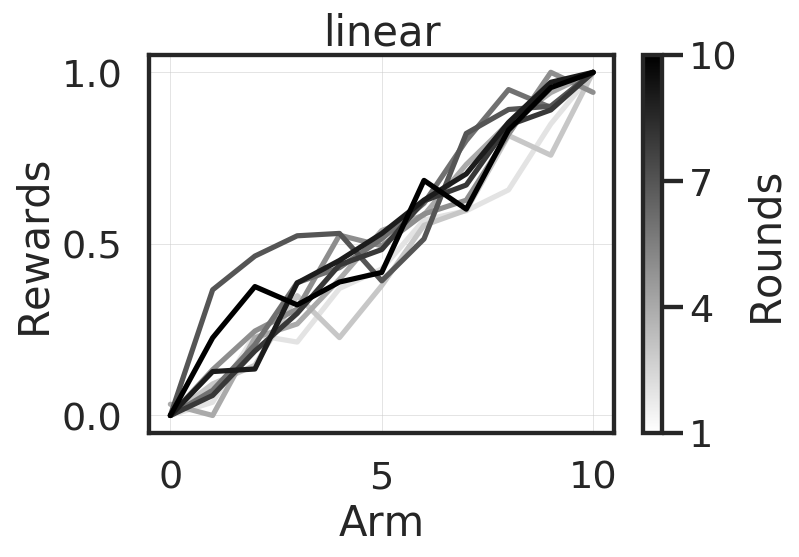

In [4]:
cue = 'linear'

#set up the color scheme
c = np.arange(n_rounds) + 1
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray_r)
cmap.set_array([])

# set up figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=125)
arms = ['A', 'S', 'D', 'F', 'J', 'K', 'L', ';']#,'""']
X, Y = task.sample(end_rnd=n_rounds, cue=cue, noise_var=2.)#, noise_var=5.)
for rnd_ix in range(n_rounds):
    #ax.plot(arms, Y[rnd_ix].numpy(), c=cmap.to_rgba(rnd_ix + 1))
    ax.plot(Y[rnd_ix].numpy(), c=cmap.to_rgba(rnd_ix + 1))
ax.grid(lw=0.3)
ax.set(title = cue, xlabel='Arm', ylabel='Rewards')
cbar = plt.colorbar(cmap, ticks=round_label, ax=ax)
cbar.set_label('Rounds', rotation=90)
plt.show()

## Compositional structures

In [5]:
from compositional_metarl.task import CompositionalBandit

In [6]:
CUES =  {'linpos': torch.tensor([1.0, 0.0, 1.0]), 'linneg': torch.tensor([1.0, 0., 0.]),
         'perodd': torch.tensor([0.0, 1.0, 0.]),  'pereven': torch.tensor([0.0, 1.0, 1.])}
bandit = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=True, noise_per_arm=noise_per_arm)

In [7]:
rules = {'add': torch.tensor([-1.]), 'chngpnt': torch.tensor([1.])}
task = CompositionalBandit(bandit, rules, num_rounds=1)

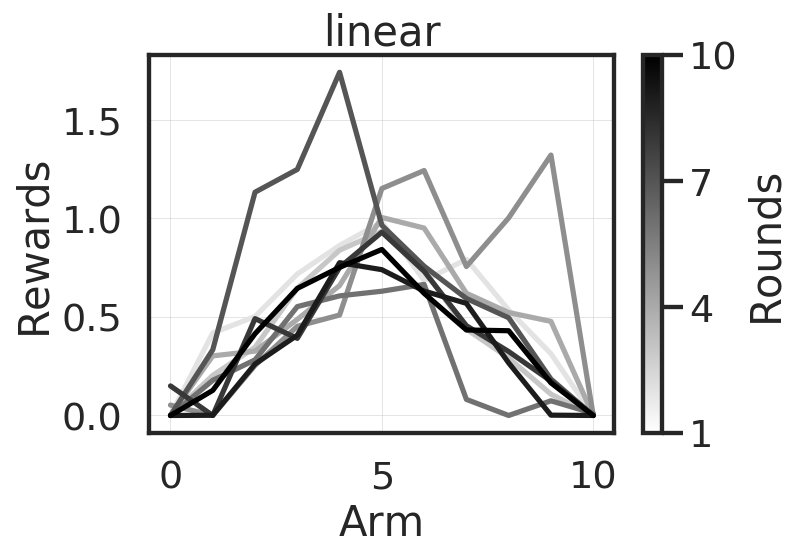

In [8]:
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=125)
arms = ['A', 'S', 'D', 'F', 'J', 'K', 'L', ';'] # , '""' ]
X, Y = task.sample(end_rnd=10, cue='linpos_linneg_chngpnt') # cue1='linpos', cue2='perodd', rule='add')
for rnd_ix in range(Y.shape[0]):
    ax.plot(Y[rnd_ix].numpy(), c=cmap.to_rgba(rnd_ix + 1))
    #ax.plot(arms, Y[rnd_ix].numpy(), c=cmap.to_rgba(rnd_ix + 1))
ax.grid(lw=0.3)
ax.set(title = cue, xlabel='Arm', ylabel='Rewards')
cbar = plt.colorbar(cmap, ticks=round_label, ax=ax)
cbar.set_label('Rounds', rotation=90)
plt.show()

## block MABs

In [9]:
from compositional_metarl.task import BlockMABs

In [10]:
'''init task'''

start_arm = 0
end_arm = 7
n_arms = (end_arm - start_arm) + 1
n_rounds_per_kernel = 1 # per function
n_blocks = 50
n_trials = 10

noise_per_arm = False #'per_arm'
cue_per_epoch = True
composition_block = True

CUES =  {'linear': [1., 0.],  'periodic': [0., 1.], 'linperiodic': [1., 1.]}
ctx_dim = len(CUES['linear'])
normalize_rewards = True
n_cues = len(CUES)
aoi = {'linear': 7, 'periodic': 1,
       'linperiodic': 6}   

In [11]:
bandit = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, 
                        normalize=normalize_rewards, noise_per_arm=noise_per_arm, cue_per_epoch=cue_per_epoch,
                        best_arms=aoi)
task = BlockMABs(bandit, cues=None, composition_block=composition_block, num_blocks=n_blocks, num_rounds=n_rounds_per_kernel) 

In [12]:
#task.evaluate_control()
block = ['linear', 'periodic', 'linperiodic']
X, Y, S = task.sample(end_rnd=1, block=block)

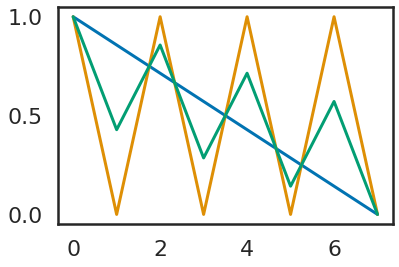

In [13]:
plt.plot(Y.T)
plt.show()

## individual structure

In [5]:
CUES =  {'linperiodic': torch.tensor([0.0, 1.0])}  #, 'periodic': torch.tensor([1.0, 0.0]), 'linperiodic': torch.tensor([1.0, 1.0])}  

In [ ]:
aoi = {'linear': 7, 'periodic': 6, 'linperiodic': 6}
rew = ['lin', 'per', 'lin-per']
c = ['r', 'k', 'b']
rew_mean, rew_err= [], []
f, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
for idx, cue in enumerate(CUES):
    X, Y = task.sample(end_rnd=n_rounds, cue=cue)
    y = Y.T# torch.stack(Y, axis=1)
    ax[0].plot( y.detach().numpy(), c[idx])
    ax[0].grid(lw=0.3)
    rew_mean.append(y[aoi[cue]].mean())
    rew_err.append(y[aoi[cue]].std())

ax[1].errorbar(rew, rew_mean, yerr=rew_err, c='k')
ax[1].bar(rew, rew_mean, color=['r', 'k', 'b'])
ax[0].set(xlabel='Arm', ylabel='Reward')
ax[1].set(xlabel='Structures')#, ylabel='Mean reward for best arm ')
sns.despine()
plt.show()